In [1]:
import json
import re
from sqlalchemy import create_engine
from config import db_password
import psycopg2
from psycopg2.extras import RealDictCursor

In [2]:
#establishing the connection
conn = psycopg2.connect(
   database="capstone_db", user='postgres', password=db_password,
   host='capstone.cjj05msruqqh.us-east-2.rds.amazonaws.com', port= '5432', 
   cursor_factory=RealDictCursor
)

#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

In [3]:
# import dependencies
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Retrieving data
cursor.execute('''SELECT * from us_county_sociohealth_data''')
#Fetching all rows from the table
result = cursor.fetchall();
## socio_health_df = pd.DataFrame([i.copy() for i in result])
## socio_health_df.head()

# Read from flat file
socio_health_df = pd.read_csv('Resources/us_county_sociohealth_data.csv')
socio_health_df.head()

,SN,fips,state,county,lat,lon,total_population,area_sqmi,population_density_per_sqmi,num_deaths,...,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability
0,1,1001,Alabama,Autauga,32.534928,-86.642748,55049,594.446120,92.605533,791,...,0.6339,0.5355,0.5976,0.6791,0.7268,0.2477,0.3298,0.1251,0.2881,0.3773
1,2,1003,Alabama,Baldwin,30.727489,-87.722575,199510,1589.807425,125.493187,2967,...,0.5253,0.5282,0.5294,0.9733,0.5387,0.2639,0.0872,0.3438,0.3324,0.2757
2,3,1005,Alabama,Barbour,31.869589,-85.393213,26614,884.875776,30.076538,472,...,0.9042,0.6979,0.8558,0.2814,0.9370,0.4438,0.8816,0.9427,0.9312,0.9847
3,4,1007,Alabama,Bibb,32.998634,-87.126480,22572,622.582355,36.255444,471,...,0.6450,0.3553,0.5018,0.4072,0.9249,0.0248,0.5645,0.9156,0.6663,0.5737
4,5,1009,Alabama,Blount,33.980878,-86.567383,57704,644.806508,89.490412,1085,...,0.4238,0.7482,0.5992,0.1344,0.8465,0.5056,0.1907,0.1515,0.1827,0.4986


In [5]:
# Change data types
socio_health_df["Temp"] = socio_health_df.state.astype(str)
socio_health_df["county"] = socio_health_df.county.astype(str)
socio_health_df["num_deaths"] = pd.to_numeric(socio_health_df['num_deaths'], errors='coerce')
# socio_health_df["county"] = socio_health_df.county.astype(float)
# = df['column'].astype(str)

In [6]:
# make a new column from turple of lat and lon
latitude = socio_health_df['lat'].to_list()
longitude = socio_health_df['lon'].to_list()
geolocation = list(zip(latitude, longitude))
geolocation

[(32.53492796, -86.64274781),
 (30.72748899, -87.72257524),
 (31.86958881, -85.39321291),
 (32.99863415, -87.12648014),
 (33.9808782, -86.56738341),
 (32.10053438, -85.71568627),
 (31.75241781, -86.68030288),
 (33.77143651, -85.82603459),
 (32.91435287, -85.39203349),
 (34.17592601, -85.60380039),
 (32.84786998, -86.71880376),
 (32.019777500000004, -88.2631849),
 (31.67668212, -87.83081391),
 (33.2690306, -85.86058307),
 (33.67451959, -85.51881383),
 (31.40265228, -85.98815917),
 (34.70047669, -87.80493371),
 (31.42923975, -86.99367837),
 (32.93624951, -86.24765729),
 (31.24849866, -86.45127715),
 (31.73153754, -86.31357901),
 (34.13195, -86.86758257),
 (31.43181495, -85.61100904),
 (32.32597601, -87.10647208),
 (34.45980613, -85.80411386),
 (32.59665284, -86.14916394),
 (31.12614174, -87.16158370000001),
 (34.04526554, -86.03476326),
 (33.72123026, -87.73886639),
 (34.44169874, -87.84373986),
 (31.0950592, -85.83909125),
 (32.85315674, -87.9522131),
 (32.76266973, -87.62915115),
 (31.

In [8]:
# import acute_care_hospital_locations data
cursor.execute('''SELECT * from acute_care_hospital_locations''')
#Fetching all rows from the table
result1 = cursor.fetchall();

cond_acute_care_df = pd.DataFrame([i.copy() for i in result1])
cond_acute_care_df.head()

,NAME,ADDRESS,CITY,STATE,ZIP,LATITUDE,LONGITUDE,GEOLOCATION
0,LOS ROBLES HOSPITAL & MEDICAL CENTER - EAST CA...,150 VIA MERIDA,WESTLAKE VILAGE,CA,91362,34.154939,-118.815736,"(34.1549388720001, -118.815736391)"
1,EAST LOS ANGELES DOCTORS HOSPITAL,4060 WHITTIER BOULEVARD,LOS ANGELES,CA,90023,34.023647,-118.184165,"(34.023647302, -118.184164805)"
2,SOUTHERN CALIFORNIA HOSPITAL AT HOLLYWOOD,6245 DE LONGPRE AVENUE,HOLLYWOOD,CA,90028,34.096391,-118.325235,"(34.0963913570001, -118.325234871)"
3,KINDRED HOSPITAL BALDWIN PARK,14148 FRANCISQUITO AVENUE,BALDWIN PARK,CA,91706,34.063039,-117.967438,"(34.063038932, -117.967437788)"
4,LAKEWOOD REGIONAL MEDICAL CENTER,3700 EAST SOUTH STREET,LAKEWOOD,CA,90712,33.859707,-118.148403,"(33.8597066200001, -118.148402965)"


In [8]:
LATITUDE = cond_acute_care_df['LATITUDE'].to_list()
LONGITUDE = cond_acute_care_df['LONGITUDE'].to_list()
GEOLOCATION = list(zip(LATITUDE, LONGITUDE))
GEOLOCATION

[(34.1549388720001, -118.815736391),
 (34.023647302, -118.184164805),
 (34.0963913570001, -118.325234871),
 (34.063038932, -117.967437788),
 (33.8597066200001, -118.148402965),
 (34.1487586590001, -117.99266765700001),
 (34.0494660590001, -118.138262231),
 (33.8580833070001, -117.553858035),
 (41.4800562550001, -120.54574398700001),
 (36.659030455999996, -121.645983804),
 (33.7474607400001, -117.831055631),
 (33.934495886, -117.893948792),
 (33.7635332090001, -117.99525596299999),
 (36.320843946, -119.34823452799999),
 (30.006906976999996, -91.79452385299999),
 (31.32360364, -95.43889930599993),
 (32.8239916700001, -92.65664868100001),
 (32.0600399510001, -92.099137669),
 (33.8070928700001, -118.19338992899999),
 (37.706406198, -122.16465451799999),
 (31.985430321, -81.15455636899999),
 (32.886297701, -84.33650698799991),
 (32.0669623380001, -84.2560501999999),
 (33.3848346460001, -84.757746692),
 (18.380443000000106, -65.95579000000001),
 (43.035812152000105, -88.037265823),
 (31.2521

In [9]:
# determine if county is medical desert
import geopy.distance
from vincenty import vincenty

min_dist = []
med_desert = []
for i in geolocation:
    dist_list = []
    for j in GEOLOCATION:
        dist = vincenty(i, j, miles=True)
        dist_list.append(dist)
    min_dist.append(min(dist_list))
    if min(dist_list)>60:
        med_desert.append('Yes')
    else:
        med_desert.append('No')
socio_health_df['Is_Medical_Desert'] = med_desert
socio_health_df.head()

,SN,fips,state,county,lat,lon,total_population,area_sqmi,population_density_per_sqmi,num_deaths,...,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability,Temp,Is_Medical_Desert
0,1,1001,Alabama,Autauga,32.534928,-86.642748,55049,594.446120,92.605533,791.0,...,0.5976,0.6791,0.7268,0.2477,0.3298,0.1251,0.2881,0.3773,Alabama,No
1,2,1003,Alabama,Baldwin,30.727489,-87.722575,199510,1589.807425,125.493187,2967.0,...,0.5294,0.9733,0.5387,0.2639,0.0872,0.3438,0.3324,0.2757,Alabama,No
2,3,1005,Alabama,Barbour,31.869589,-85.393213,26614,884.875776,30.076538,472.0,...,0.8558,0.2814,0.9370,0.4438,0.8816,0.9427,0.9312,0.9847,Alabama,No
3,4,1007,Alabama,Bibb,32.998634,-87.126480,22572,622.582355,36.255444,471.0,...,0.5018,0.4072,0.9249,0.0248,0.5645,0.9156,0.6663,0.5737,Alabama,No
4,5,1009,Alabama,Blount,33.980878,-86.567383,57704,644.806508,89.490412,1085.0,...,0.5992,0.1344,0.8465,0.5056,0.1907,0.1515,0.1827,0.4986,Alabama,No


In [10]:
# keep only relevant columns
sh_category_df = socio_health_df[['lat', 'lon', 'percent_fair_or_poor_health', 'average_number_of_physically_unhealthy_days',
                                'percent_smokers', 'percent_adults_with_obesity', 'food_environment_index', 'percent_physically_inactive',
                                 'percent_excessive_drinking', 'teen_birth_rate', 'percent_uninsured', 'Is_Medical_Desert']].dropna(axis=0)
sh_category_df.head()

,lat,lon,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,percent_smokers,percent_adults_with_obesity,food_environment_index,percent_physically_inactive,percent_excessive_drinking,teen_birth_rate,percent_uninsured,Is_Medical_Desert
0,32.534928,-86.642748,20.882987,4.743889,18.081557,33.3,7.2,34.7,15.026031,25.284927,8.721686,No
1,30.727489,-87.722575,17.509134,4.224519,17.489033,31.0,8.0,26.5,17.958310,27.880692,11.333404,No
2,31.869589,-85.393213,29.591802,5.430279,21.999985,41.7,5.6,23.5,12.844016,40.870815,12.242792,No
3,32.998634,-87.126480,19.439724,4.591482,19.114200,37.6,7.8,33.5,15.570042,41.696794,10.206253,No
4,33.980878,-86.567383,21.745293,4.860808,19.208672,33.8,8.4,30.3,14.230594,33.534595,13.360759,No


In [11]:
# encode categorical data

sh_category_encoded = pd.get_dummies(sh_category_df, columns=['Is_Medical_Desert'])
sh_category_encoded.head()

,lat,lon,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,percent_smokers,percent_adults_with_obesity,food_environment_index,percent_physically_inactive,percent_excessive_drinking,teen_birth_rate,percent_uninsured,Is_Medical_Desert_No,Is_Medical_Desert_Yes
0,32.534928,-86.642748,20.882987,4.743889,18.081557,33.3,7.2,34.7,15.026031,25.284927,8.721686,1,0
1,30.727489,-87.722575,17.509134,4.224519,17.489033,31.0,8.0,26.5,17.958310,27.880692,11.333404,1,0
2,31.869589,-85.393213,29.591802,5.430279,21.999985,41.7,5.6,23.5,12.844016,40.870815,12.242792,1,0
3,32.998634,-87.126480,19.439724,4.591482,19.114200,37.6,7.8,33.5,15.570042,41.696794,10.206253,1,0
4,33.980878,-86.567383,21.745293,4.860808,19.208672,33.8,8.4,30.3,14.230594,33.534595,13.360759,1,0


In [12]:
sh_category_encoded.dtypes

lat                                            float64
lon                                            float64
percent_fair_or_poor_health                    float64
average_number_of_physically_unhealthy_days    float64
percent_smokers                                float64
percent_adults_with_obesity                    float64
food_environment_index                         float64
percent_physically_inactive                    float64
percent_excessive_drinking                     float64
teen_birth_rate                                float64
percent_uninsured                              float64
Is_Medical_Desert_No                             uint8
Is_Medical_Desert_Yes                            uint8
dtype: object

In [13]:
sh_category_encoded['Is_Medical_Desert_Yes'].value_counts()

0    2891
1      79
Name: Is_Medical_Desert_Yes, dtype: int64

In [14]:
# Calcuculate average sick days for medical deserts and non-medical deserts
ave_sick_days = sh_category_encoded.groupby('Is_Medical_Desert_Yes')['average_number_of_physically_unhealthy_days'].mean()
ave_sick_days

Is_Medical_Desert_Yes
0    4.027548
1    3.855100
Name: average_number_of_physically_unhealthy_days, dtype: float64

In [15]:
# extract the dataframe for medical deserts
medical_desert_df = socio_health_df[socio_health_df['Is_Medical_Desert'] == 'Yes']
medical_desert_df.head()

,SN,fips,state,county,lat,lon,total_population,area_sqmi,population_density_per_sqmi,num_deaths,...,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability,Temp,Is_Medical_Desert
67,68,2013,Alaska,Aleutians East,55.685432,-161.244412,3299,6981.956449,0.472504,NaN,...,0.9946,0.5400,0.1493,0.7393,0.9914,0.9994,0.9121,0.5307,Alaska,Yes
68,69,2016,Alaska,Aleutians West,53.667750,-166.890423,5714,4390.257721,1.301518,NaN,...,0.9784,0.9599,0.0672,0.9911,0.9831,0.9933,0.9955,0.4537,Alaska,Yes
70,71,2050,Alaska,Bethel,60.947311,-159.522361,17885,40570.105550,0.440842,249.0,...,0.9465,0.6125,0.1130,0.9994,0.9984,0.7160,0.9179,0.9628,Alaska,Yes
71,72,2060,Alaska,Bristol Bay,58.741951,-156.702879,942,503.849891,1.869604,NaN,...,0.4222,0.3572,0.1815,0.9296,0.9064,0.8138,0.8402,0.2996,Alaska,Yes
72,73,2068,Alaska,Denali,63.673197,-150.009455,2125,12747.590340,0.166698,NaN,...,0.1977,0.3687,0.4253,0.9704,0.0019,0.9892,0.6199,0.0232,Alaska,Yes


In [16]:
# import dependencies for machine learning
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [17]:
# Split data into feature and target
y = sh_category_encoded['average_number_of_physically_unhealthy_days']
X = sh_category_encoded.drop(['average_number_of_physically_unhealthy_days', 'Is_Medical_Desert_No'], axis=1)

In [18]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [19]:
# instanciate a LinearRegression model
model = LinearRegression()

In [20]:
# Train the model with the training data
model.fit(X_train, y_train)

LinearRegression()

In [21]:
# test the model with the test data
y_pred = model.predict(X_test)
print(y_pred.shape)

(743,)


In [22]:
# print model coeficient (slope) and intercept
print(model.coef_)
print(model.intercept_)

[-0.0011175  -0.00369706  0.09546798  0.07257437 -0.00805024  0.00212782
 -0.00208574 -0.02993963 -0.00194404 -0.01598469 -0.10782818]
1.7893536718047893


In [23]:
print(X_test.shape)
print(y_pred.shape)
y_pred[:20,]

(743, 11)
(743,)


array([4.1169939 , 4.32210317, 3.9128326 , 3.77646652, 3.0724463 ,
       3.66169602, 3.34310769, 4.88469874, 4.15044843, 4.41051328,
       3.5337209 , 3.82672115, 4.21246316, 5.17160126, 3.48047489,
       4.0943552 , 3.69819074, 4.49989952, 3.70349634, 3.90834828])

In [24]:
y_test[:20,]

2877    3.748159
2159    4.370432
2205    3.911805
900     3.613579
2812    3.286540
2229    3.795122
1373    3.028311
120     4.820256
727     3.968153
785     4.491379
973     3.193085
2085    3.748394
2098    4.258425
45      5.285484
2111    3.549306
1082    4.302176
2547    3.910189
2294    4.636788
2643    3.928370
908     3.873692
Name: average_number_of_physically_unhealthy_days, dtype: float64

In [25]:
# calculate R2 (accuracy) score
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.8712171904331886


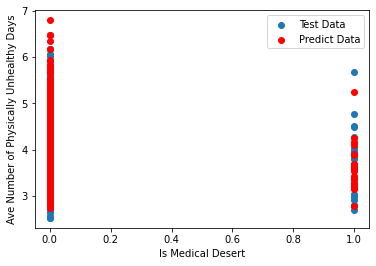

In [26]:
# create scatter plot
plt.scatter(X_test.Is_Medical_Desert_Yes, y_test)
plt.scatter(X_test.Is_Medical_Desert_Yes, y_pred, color='red')
plt.xlabel('Is Medical Desert')
plt.ylabel('Ave Number of Physically Unhealthy Days')
plt.legend(['Test Data', 'Predict Data'])
plt.show()

<ipython-input-27-3eef531f74e1>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


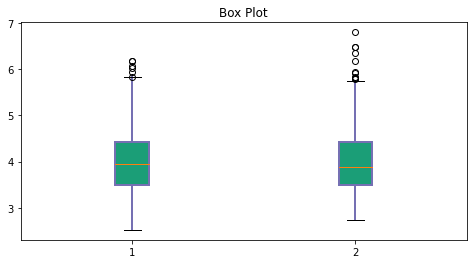

In [27]:
# create box plot
data = [y_test, y_pred]
# Create a figure instance
fig = plt.figure(1, figsize=(8, 4))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data, patch_artist=True)
# change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
    
ax.set_title('Box Plot')
fig.show()


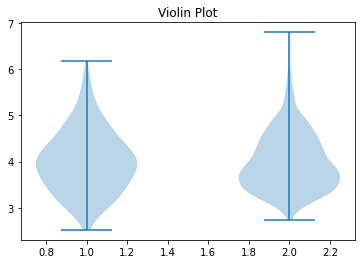

In [28]:
# make a violin plot

# Extract Figure and Axes instance
fig, ax = plt.subplots()

# Create a plot
ax.violinplot([y_test, y_pred])

# Add title
ax.set_title('Violin Plot')
plt.show()

In [29]:
# initialize the map aroun US
import folium
from folium import Choropleth
us_map = folium.Map(location=[35.0522,-100.2437], tiles='OpenStreetMap', zoom_start=4)

us_area = 'https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_outline_5m.json'
us_counties = 'https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_5m.json'

folium.GeoJson(us_area).add_to(us_map)
# folium.GeoJson(us_counties).add_to(us_map)

#for each row in the medical desert dataset, plot the corresponding latitude and longitude on the map
for i,row in medical_desert_df.iterrows():
    folium.CircleMarker((row.lat,row.lon), radius=3, weight=2, color='red', fill_color='red', fill_opacity=.5,
                        popup=f"COUNTY: {row.county}, STATE: {row.state}, Num of Sick days: {row.average_number_of_physically_unhealthy_days:.2f}, SVI: {row.percentile_rank_social_vulnerability:.2f}", title="US Medical Deserts").add_to(us_map)


#save the map as an html    
us_map.save('Resources/CountySVI_map2.html')
us_map


In [30]:
# find number of medical desert counties in each state
states_df = medical_desert_df.groupby('state')['county'].count()
states_df.columns =['NAME']
states_df = states_df.sort_values(ascending=False)
states_df

state
Montana         25
North Dakota    23
Alaska          20
Nebraska        12
South Dakota     8
Wyoming          6
Texas            4
Oregon           3
Utah             3
Minnesota        3
Idaho            3
New Mexico       2
Washington       2
Maine            2
Nevada           2
Colorado         1
Arizona          1
Name: county, dtype: int64

C:\Users\kolao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


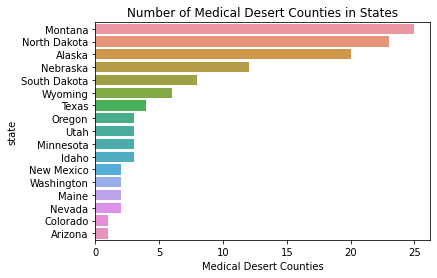

In [31]:
import seaborn as sns 
fig = sns.barplot(states_df,states_df.index, order=states_df.index)
plt.title("Number of Medical Desert Counties in States")
plt.xlabel("Medical Desert Counties")
plt.savefig("states_df",bbox_inches="tight")
plt.show(fig)

In [32]:
len(states_df)
states_df

state
Montana         25
North Dakota    23
Alaska          20
Nebraska        12
South Dakota     8
Wyoming          6
Texas            4
Oregon           3
Utah             3
Minnesota        3
Idaho            3
New Mexico       2
Washington       2
Maine            2
Nevada           2
Colorado         1
Arizona          1
Name: county, dtype: int64